In [37]:
# import computer vision libraries
import torchvision
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

### Getting the Data

In [2]:
# Setup trainig data
from torchvision import datasets

train_data = datasets.FashionMNIST(
                                   root="data", 
                                   train = True,
                                   download=True,
                                   transform=torchvision.transforms.ToTensor(),
                                   target_transform=None
                                   )

test_data = datasets.FashionMNIST(
                                  root="data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor(),
                                  target_transform=None
                                  )

In [36]:
class_name = train_data.classes
class_to_idx = train_data.class_to_idx

### Loading data to DataLoader

In [39]:
from torch.utils.data import DataLoader

# setup batch size
BATCH_SIZE = 32

# Loading to DataLoader
train_dataloader = DataLoader(dataset=train_data, batch_size= BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(dataset=test_data , batch_size=BATCH_SIZE, shuffle=False)

In [40]:
# Lets check out what's created 
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000025443BDC220>, <torch.utils.data.dataloader.DataLoader object at 0x0000025443BDC9D0>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


### Funtion to time the model

In [8]:
from timeit import default_timer as timer 
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """ Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time: .3f} seconds")
    return total_time

### Setting up device agnostic code

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### TinyVGG CNN model

In [41]:
# Create a convolutional neural network
class FashionMNIST(nn.Module):
    """
    Model architecture that replicates that replicates TinyVGG
    model from CNN explainer website 
    """
    def __init__(self, input_shape: int , hidden_units: int , output_shape: int) :
        super().__init__()
        self.conv_block_1 = nn.Sequential(
                                        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2)
                                        )
        self.conv_block_2 = nn.Sequential(
                                        nn.Conv2d(in_channels= hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2)
                                        )
        self.classifier = nn.Sequential(
                                        nn.Flatten(),
                                        nn.Linear(in_features=hidden_units * 7 *7,
                                                   out_features=output_shape) 
                                        )
        
    def forward(self,x):
        x = self.conv_block_1(x)
        #print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        #print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        #print(f"Output shape of classifier: {x.shape}")
        return x

In [42]:
model = FashionMNIST(input_shape= 1, hidden_units=10 ,output_shape=len(class_name)).to(device)

### Setting up Loss function, Accuracy function and optimizer

In [43]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

### Training and Testing function

In [44]:
# Training function
torch.manual_seed(42)
def Train_step(model: torch.nn.Module, 
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module, 
                optimizer:torch.optim.Optimizer, 
                accuracy_fn:accuracy_fn , device:torch.device=device):
    
    train_loss ,train_acc = 0 , 0
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device) , y.to(device)

        y_pred = model(X)
        
        loss = loss_fn(y_pred,y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()


    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")
        

In [45]:
# Testing
def Test_step(model: torch.nn.Module, dataloader:torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn: accuracy_fn, device:torch.device=device): # No optimizer as we are just evaluating the modle
    test_loss , test_acc = 0,0
    model.eval()
    with torch.inference_mode():

        for X_test , y_test in dataloader:

            X_test, y_test = X_test.to(device) , y_test.to(device)
            test_pred = model(X_test)

            loss = loss_fn(test_pred, y_test)
            test_loss += loss

            acc = accuracy_fn(y_true=y_test, y_pred= test_pred.argmax(dim=1))
            test_acc += acc

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        
        print(f"Test loss: { test_loss:.4f}, Test acc: { test_acc:.4f}%")
    

### Training and testing loop

In [47]:
from tqdm.auto import tqdm


# Measure time
from timeit import default_timer as timer 
train_time_start_model = timer()

# Train and test model
epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n-----")
    Train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn,device=device)

    Test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model, end=train_time_end_model, device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 
-----
Train loss: 0.46812 | Train acc: 82.76%


 20%|██        | 1/5 [01:27<05:49, 87.33s/it]

Test loss: 0.4101, Test acc: 85.0839%
Epoch: 1 
-----
Train loss: 0.35173 | Train acc: 87.21%


 40%|████      | 2/5 [02:47<04:09, 83.19s/it]

Test loss: 0.3394, Test acc: 87.7796%
Epoch: 2 
-----
Train loss: 0.32081 | Train acc: 88.26%


 60%|██████    | 3/5 [03:58<02:35, 77.52s/it]

Test loss: 0.3399, Test acc: 87.9892%
Epoch: 3 
-----
Train loss: 0.30263 | Train acc: 89.07%


 80%|████████  | 4/5 [04:56<01:10, 70.05s/it]

Test loss: 0.3715, Test acc: 85.7129%
Epoch: 4 
-----
Train loss: 0.28703 | Train acc: 89.46%


100%|██████████| 5/5 [05:57<00:00, 71.56s/it]

Test loss: 0.3374, Test acc: 88.0092%
Train time on cpu:  357.787 seconds


### Model Evaluation function

In [48]:
from torch.utils.data import DataLoader
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader , loss_fn: torch.nn.Module, accuracy_fn, device:torch.device=device):
    """ Returns a dictionary containing the results of model predicting on data_loader"""
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device) , y.to(device)
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {"model_name": model.__class__.__name__, ### Only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


In [49]:
# Get model_2 results
model_results = eval_model(model=model, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

model_results

100%|██████████| 313/313 [00:04<00:00, 73.26it/s]


{'model_name': 'FashionMNIST',
 'model_loss': 0.337446004152298,
 'model_acc': 88.00918530351437}

### Making random predictions

In [50]:
def make_predictions(model: torch.nn.Module, data:list, device: torch.device=device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model ouputs raw logits)
            pred_logits = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

            # Get pred_prob off the gpu for further calculation
            pred_probs.append(pred_prob.cpu())

# Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [51]:
import random 
test_samples = []
test_labels = []
for sample , label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [52]:
pred_probs = make_predictions(model=model, data = test_samples)
pred_classes = pred_probs.argmax(dim=1)

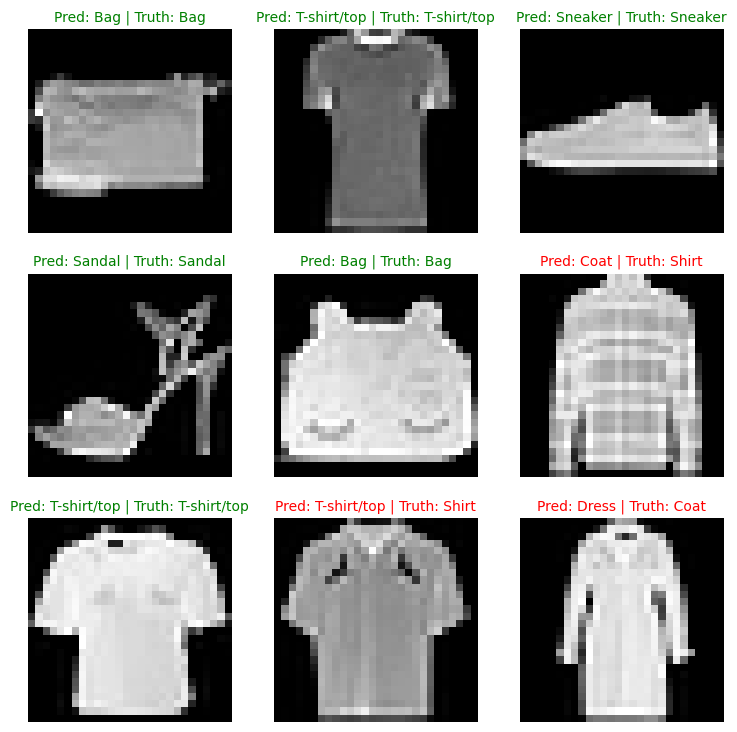

In [53]:
# Plot predictions 
plt.figure(figsize=(9,9))
nrows = 3
ncolumns = 3
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncolumns, i+1) # i+1 because it can't starts with 0

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction (in text form, e.g "Sandal")
    pred_label = class_name[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = class_name[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')

    else:
        plt.title(title_text, fontsize=10, c="r")

    plt.axis(False)

### Finding the relationship

In [54]:
# Import tqdm.auto
from tqdm.auto import tqdm

# Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send the data and targets to target device
        X , y = X.to(device), y.to(device)

        # Do the forward pass
        y_logit = model(X)

        # Turn predictions from logits -> prediction probabilities -> prediction labels
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

        # Put prediction on CPU for evaluation 
        y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions: 100%|██████████| 313/313 [00:04<00:00, 63.74it/s]


tensor([9, 2, 1,  ..., 0, 1, 7])

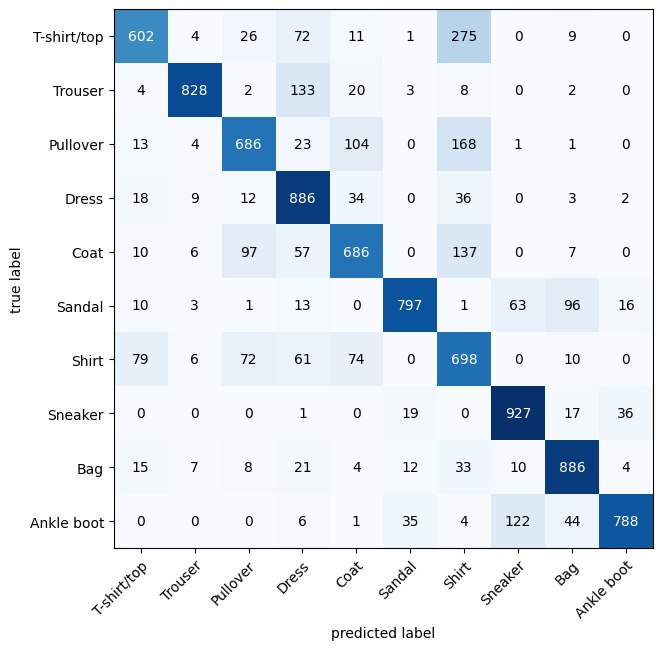

In [55]:
import mlxtend, torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare predictions to targets 
confmat = ConfusionMatrix(task="multiclass",num_classes = len(class_name))
confmat_tensor = confmat(preds = y_pred_tensor, target = test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), # Matplotlib likes working with numpy
                                class_names=class_name,
                                figsize=(10,7))

### Saving the model

In [56]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("FASHION_MNIST")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save
MODEL_NAME = "Fashion_MNIST_Model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict() , f=MODEL_SAVE_PATH)

Saving model to: FASHION_MNIST\Fashion_MNIST_Model.pth
